In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
import time
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = None
pd.options.display.max_rows = 80
%matplotlib inline
import statsmodels.api as sm

In [7]:
df = pd.read_csv("Super_Store.csv",sep=",", encoding='cp1252')
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310


In [9]:
df1 = df[['Order Date', 'Sales']]
df1

,Order Date,Sales
0,11/8/2016,261.9600
1,11/8/2016,731.9400
2,10/11/2015,957.5775
3,6/9/2014,48.8600
4,6/9/2014,1706.1840
...,...,...
2116,3/19/2015,383.4656
2117,12/5/2016,13.4000
2118,9/6/2015,85.9800
2119,1/21/2014,25.2480


In [10]:
df1['Order Date'] = pd.to_datetime(df1['Order Date'])
df1 = df1.sort_values('Order Date')
df1 = df1.groupby('Order Date')['Sales'].sum().reset_index()
df1.set_index('Order Date', inplace = True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889 entries, 2014-01-06 to 2017-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   889 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


In [12]:
y = df1['Sales'].resample('MS').mean()

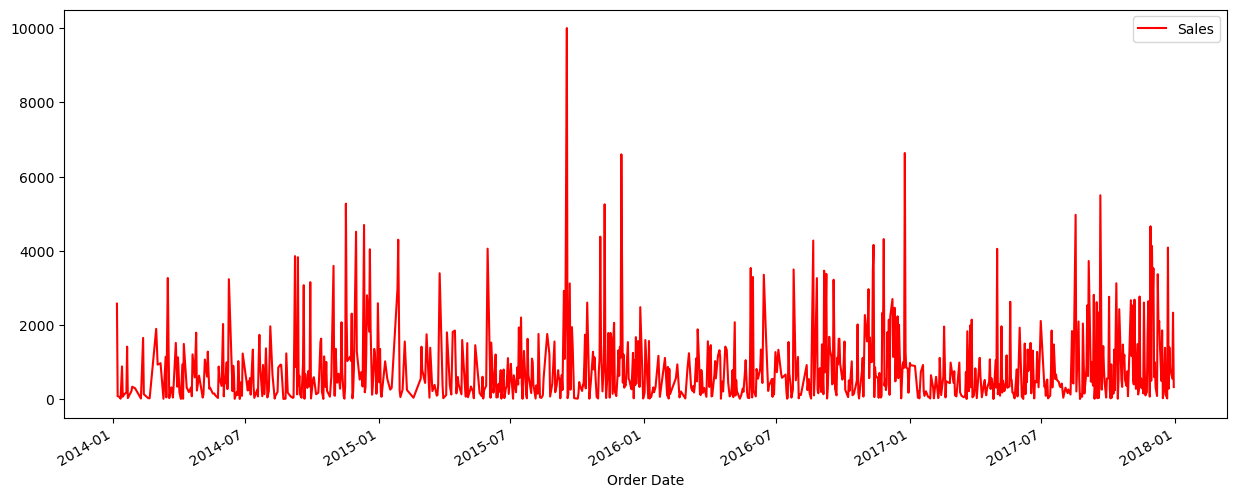

In [31]:
df1.plot(figsize = (15,6), color='red')
plt.show()

In [14]:
y = df1['Sales'].resample('MS').mean()

In [15]:
y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

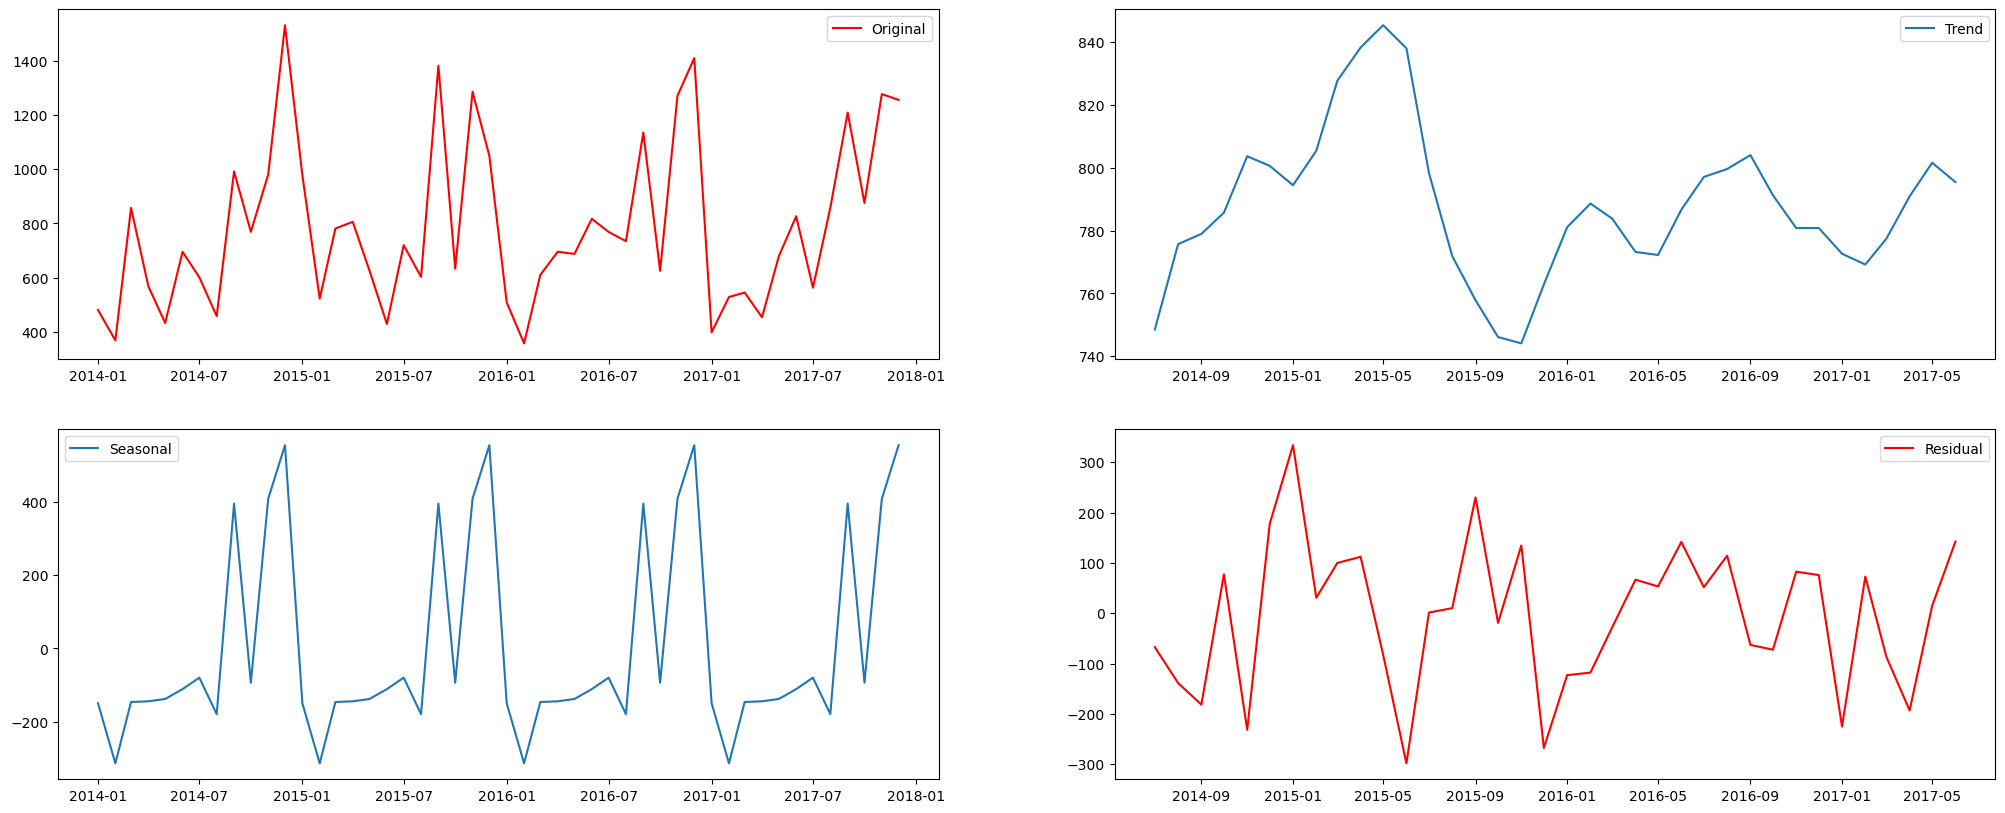

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

decomposition = seasonal_decompose(y)
fig, ax = plt.subplots(2,2, figsize=(25,10))
ax[0,0].plot(y, label = 'Original', color='red')
ax[0,0].legend(loc = 'best')

trend = decomposition.trend
ax[0,1].plot(trend, label = 'Trend')
ax[0,1].legend(loc = 'best')

seasonal = decomposition.seasonal
ax[1,0].plot(seasonal, label = 'Seasonal')
ax[1,0].legend(loc = 'best')

residual = decomposition.resid
ax[1,1].plot(residual, label = 'Residual', color='red')
ax[1,1].legend(loc='best')
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [22]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
start= time.time()
from pylab import rcParams
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False, 
enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
print(time.time() - start)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1394.3784797316462
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919128
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793718
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1361.1961874181322
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280301486
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758097
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2690.086542846727
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673289
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.58219615257707
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2593.170552065809
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946871
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255764596034
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1483.6059844595095
ARIMA

In [25]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0949      0.313     -0.303      0.762      -0.708       0.518
ma.L1         -1.0000      0.415     -2.409      0.016      -1.814      -0.186
ar.S.L12      -0.0036      0.424     -0.008      0.993      -0.834       0.827
ma.S.L12      -0.3011      0.501     -0.601      0.548      -1.283       0.681
sigma2      2.476e+04   1.68e-05   1.48e+09      0.000    2.48e+04    2.48e+04


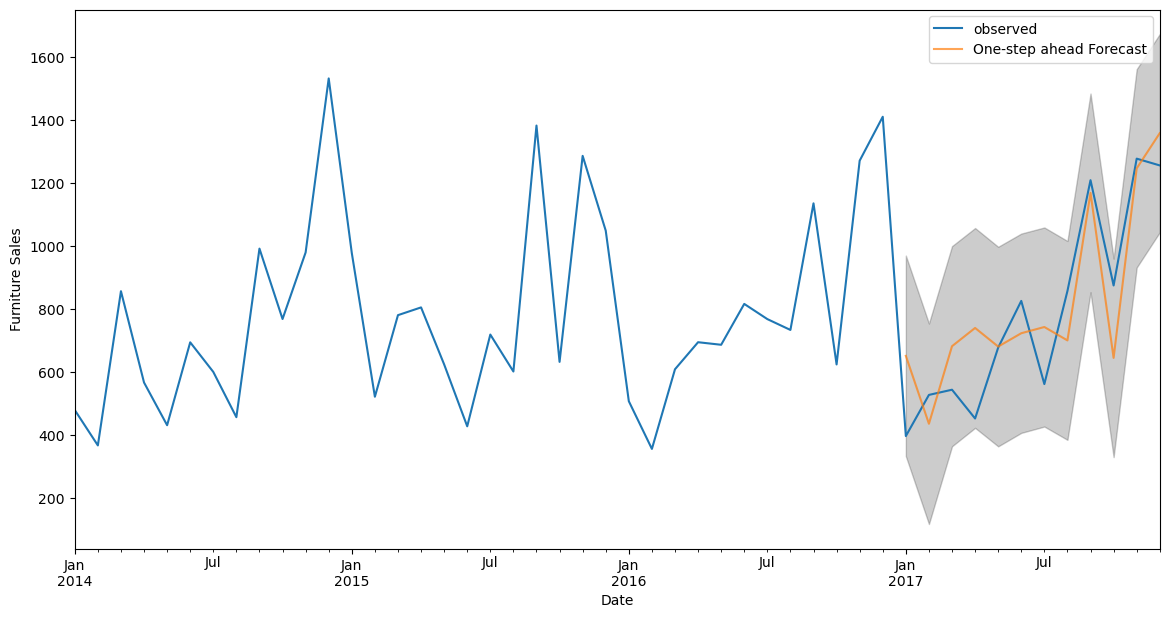

In [27]:
#set forecasts to start at 2017–01–01 to the end of the data to forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 25708.54
The Root Mean Squared Error of our forecasts is 160.34


            lower Sales  upper Sales
2018-01-01   180.621349   809.064322
2018-02-01   186.312839   815.743658
2018-03-01   282.723430   912.319332
2018-04-01   231.731683   861.314515
2018-05-01   371.222074  1000.806554
2018-06-01   495.556512  1125.141366
2018-07-01   318.525201   948.110694
2018-08-01   505.351197  1134.937449
2018-09-01   900.318105  1529.905249
2018-10-01   503.963866  1133.552033
2018-11-01   970.180165  1599.769472
2018-12-01   983.032889  1612.623930
2019-01-01   113.363365   891.790054


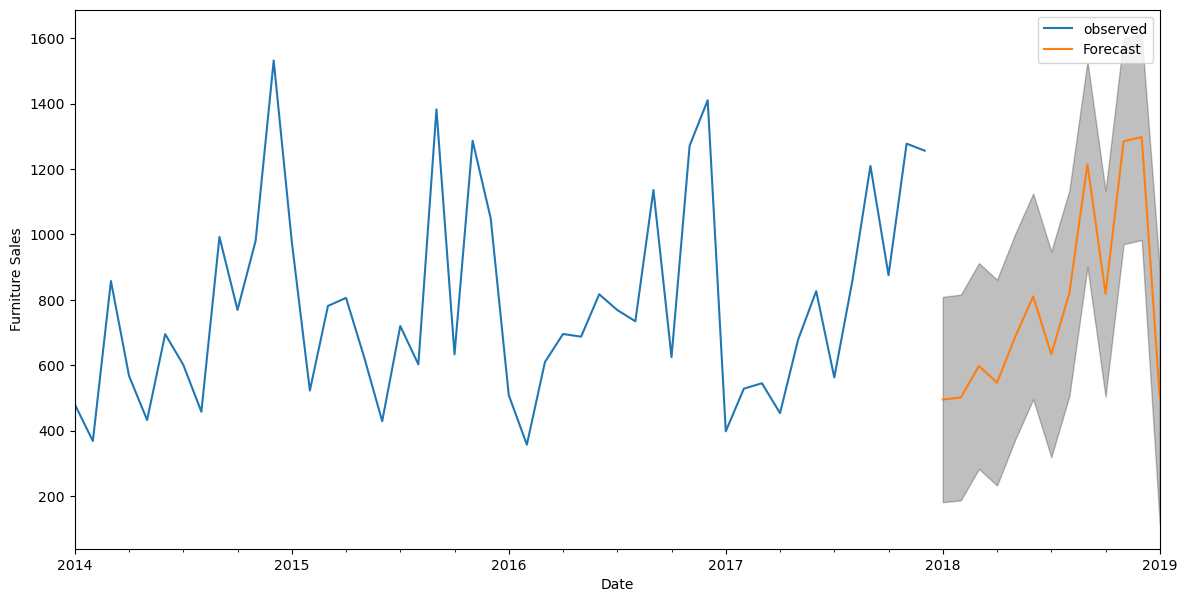

In [29]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
print(pred_ci)
plt.legend()
plt.show()